In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron as SkPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import pickle

In [3]:
class ERM:
    def __init__(self):
        self.coef_ = np.zeros(2)
    
    def fit(self, X,y):
        score = 0
        max_score = 0
        max_v=np.zeros(2)
        for x in X:
            v=np.zeros(2)
            v[0]=1
            v[1]=-x[0]/x[1]
            full_preds = np.sign(np.dot(X, v))
            score = accuracy_score(full_preds, y)
            if score>max_score:
#                 print(score)
#                 print(v/np.linalg.norm(v))
                max_score=score
                max_v=v
            v=np.zeros(2)
            v[0]=-1
            v[1]=x[0]/x[1]
            full_preds = np.sign(np.dot(X, v))
            score = accuracy_score(full_preds, y)
            if score>max_score:
#                 print(score)
#                 print(v/np.linalg.norm(v))
                max_score=score
                max_v=v
    
        self.coef_ = max_v
            
    def predict(self, X):
        return np.sign(X @ self.coef_)

In [4]:
class Perceptron:
    def __init__(self, tol=None):
        self.tol = tol
        self.fitted = False
        self.coef_ = None
        
    def fit(self, X, y):
        perm = np.random.permutation(len(X))
        X = X[perm]
        y = y[perm]
        
        self.coef_ = np.zeros(X.shape[1])
        self.best_coef_ = self.coef_
        assert(X.shape[0] == y.shape[0])
        assert(X.shape[1] == self.coef_.shape[0])
        
        counter = 0
        score = 0
        max_score = 0
        
        while(self.fitted == False):
            keep_updating = False
            full_preds = np.sign(np.dot(X, self.coef_))
            score = accuracy_score(full_preds, y)
            
            if(score <= max_score + 1e-6):
                if(score > max_score):
                    self.best_coef_ = self.coef_
                    max_score = score
                counter += 1
                #print(counter)
                #print(score)
            else:
                self.best_coef_ = self.coef_
                max_score = score
                counter = 0
            
            if(counter < 20000):
                for i, pred in enumerate(full_preds):
                    if(pred != y[i]):
                        keep_updating = True
                        self.coef_ += y[i] * X[i]
                        break 
                if(not keep_updating):
                    self.fitted = True
                #print(score)
            else:
                #print(score)
                self.fitted = True
                keep_updating = False
                       
        print(max_score)
        self.coef_ = self.best_coef_
        
    def predict(self, X):
        return np.sign(X @ self.coef_)

In [5]:
def poison_point(w, e, n):
    v=w/np.linalg.norm(w)
    p=np.zeros((n,))
    p[n-2]=1
    inner=np.inner(p,v)
    p[n-1]= -inner/v[n-1]
    p=np.cos(e*np.pi)*p/np.linalg.norm(p)
    p=np.sin(e*np.pi)*v + p
    
    return p

## Part 1: Non-Oblivious Adversary

In [6]:
def generate_datasets(seed, m, n):
    np.random.seed(seed) 
    X = np.random.standard_normal((m, n)) # Generate points
    w = np.random.standard_normal(n)
    # Produce labels
    y = np.sign(np.dot(X, w))
    
    np.random.seed(seed + 50)
    X_test = np.random.standard_normal((m, n)) # Generate points
    # Produce labels
    y_test = np.sign(np.dot(X_test, w))
#     print(w/np.linalg.norm(w))
    return X, y, X_test, y_test

In [7]:
m = 1000
n = 2
epsilons = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]

In [8]:
# Main Loop
nonobliv_epsilon_avg_dict = {}

for e in epsilons:
    print("=== EPSILON = {} ===".format(e))
    poisoned_test_accs = []
    
    for seed in range(20):
        # Generate datasets
        X, y, X_test, y_test = generate_datasets(seed, m, n)
        
        # Unpoisoned Perceptron
#         unpoisoned_clf = SkPerceptron(max_iter = 2*m, tol=None, fit_intercept=False)
        unpoisoned_clf = ERM()

        unpoisoned_clf.fit(X, y)
        unpoisoned_pred = unpoisoned_clf.predict(X)
        print("Unpoisoned Training Accuracy = {}".format(accuracy_score(unpoisoned_pred, y)))
#         print(unpoisoned_clf.coef_)

        et=e
        while et>=0:
            poison_p = poison_point(unpoisoned_clf.coef_, et, n)
            poison_y = -np.sign(np.dot(poison_p, unpoisoned_clf.coef_)) # should be 1
            duplicates = int(np.ceil(m * e))
#             print(duplicates)
            poison_rows = np.tile(poison_p, (duplicates, 1))
#             print(poison_rows)
            poisoned_X = np.vstack((X, poison_rows))
            poisoned_y = np.append(y, np.full((duplicates, 1), poison_y))
            poisoned_clf=ERM()
            poisoned_clf.fit(poisoned_X, poisoned_y)

#             print(poisoned_clf.coef_)
            if np.dot(poisoned_clf.coef_, poison_p) == 0 or np.sign(np.dot(poisoned_clf.coef_, poison_p))==poison_y:
#                 print(np.dot(poisoned_clf.coef_, poison_p))
#                 print(et)
                break
            else: 
#                 print(et)
                et=et-0.001

        # Poisoned Perceptron
#         poisoned_clf = SkPerceptron(max_iter = 10*m, tol=None, fit_intercept=False)
        poisoned_clf=ERM()
        poisoned_clf.fit(poisoned_X, poisoned_y)
#         if(poisoned_clf.predict(poison_p.reshape(-1, 2)) == -1):
        poisoned_pred = poisoned_clf.predict(X_test)
        print("Poisoned Test Accuracy = {}".format(accuracy_score(poisoned_pred, y_test)))
        poisoned_test_accs.append(accuracy_score(poisoned_pred, y_test))
    
    avg_poisoned_test_acc = np.mean(np.asarray(poisoned_test_accs))
    nonobliv_epsilon_avg_dict[e] = avg_poisoned_test_acc

=== EPSILON = 0.0 ===
Unpoisoned Training Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.998
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Unpoisoned Training Accuracy = 0.999
P

Poisoned Test Accuracy = 0.951
=== EPSILON = 0.06 ===
Unpoisoned Training Accuracy = 1.0
Poisoned Test Accuracy = 0.941
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.93
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.963
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.945
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.938
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.931
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.948
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.949
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.932
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.936
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.959
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.932
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.936
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.9

Poisoned Test Accuracy = 0.902
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.879
=== EPSILON = 0.12 ===
Unpoisoned Training Accuracy = 1.0
Poisoned Test Accuracy = 0.867
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.877
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.901
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.876
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.886
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.875
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.898
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.892
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.869
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.88
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.891
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.876
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.8

Poisoned Test Accuracy = 0.84
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.842
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.827
=== EPSILON = 0.18 ===
Unpoisoned Training Accuracy = 1.0
Poisoned Test Accuracy = 0.816
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.81
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.849
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.819
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.821
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.839
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.854
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.841
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.819
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.828
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.833
Unpoisoned Training Accuracy = 0.999
Poisoned Test Accuracy = 0.80

In [9]:
nonobliv_epsilon_avg_dict

{0.0: 0.9990500000000001,
 0.01: 0.9923,
 0.02: 0.9823999999999999,
 0.03: 0.9718499999999999,
 0.04: 0.9616499999999999,
 0.05: 0.9523999999999999,
 0.06: 0.94185,
 0.07: 0.9309,
 0.08: 0.9206000000000003,
 0.09: 0.9105500000000001,
 0.1: 0.9023,
 0.11: 0.8919500000000001,
 0.12: 0.8826499999999999,
 0.13: 0.8747000000000001,
 0.14: 0.8654999999999999,
 0.15: 0.8561,
 0.16: 0.8458,
 0.17: 0.8358999999999999,
 0.18: 0.8265499999999999,
 0.19: 0.8163,
 0.2: 0.8059999999999998}

In [10]:
#with open('nonobliv_epsilon_dict.pkl', 'wb') as f:
#    pickle.dump(nonobliv_epsilon_avg_dict, f)

In [11]:
#with open('nonobliv_epsilon_dict.pkl', 'rb') as f:
#    test = pickle.load(f)

## Part 2: Oblivious Adversary

In [12]:
# Main Loop
# 1) fixed random point, repeated m * epsilon times, label 1 (coin flip at the beginning)
# 2) multiple random points, m * epsilon of them from N(0, 1), label 1 (coin flip at the beginning)
# 3) multiple random points, m * epsilon of them from N(0, 1), label coin flip

In [13]:
# (1) Fixed Random Point, repeated m * epsilon times, label 1/-1 (coin flip at beginning)

obliv1_epsilon_avg_dict = {}

for e in epsilons:
    print("=== EPSILON = {} ===".format(e))
    poisoned_test_accs = []
    
    for seed in range(20):
        # Generate datasets
        X, y, X_test, y_test = generate_datasets(seed, m, n)
        
        poison_p = np.random.standard_normal(n)
        poison_y = np.random.choice([-1, 1])
        duplicates = int(np.ceil(m * e))
        poison_rows = np.tile(poison_p, (duplicates, 1))
        poisoned_X = np.vstack((X, poison_rows))
        poisoned_y = np.append(y, np.full((duplicates, 1), - poison_y))

        # Poisoned Perceptron
#         poisoned_clf = SkPerceptron(max_iter = 10*m, tol=None, fit_intercept=False)
        poisoned_clf=ERM()
        poisoned_clf.fit(poisoned_X, poisoned_y)
        poisoned_pred = poisoned_clf.predict(X_test)
        print("Poisoned Test Accuracy = {}".format(accuracy_score(poisoned_pred, y_test)))
        poisoned_test_accs.append(accuracy_score(poisoned_pred, y_test))
    
    avg_poisoned_test_acc = np.mean(np.asarray(poisoned_test_accs))
    obliv1_epsilon_avg_dict[e] = avg_poisoned_test_acc

=== EPSILON = 0.0 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
=== EPSILON = 0.01 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accura

Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.899
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.953
Poisoned Test Accuracy = 1.0
=== EPSILON = 0.14 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.899
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Te

In [14]:
#with open('obliv1_epsilon_avg_dict.pkl', 'wb') as f:
#    pickle.dump(obliv1_epsilon_avg_dict, f)
    
#with open('obliv1_epsilon_avg_dict.pkl', 'rb') as f:
#    test = pickle.load(f)
    
#test
obliv1_epsilon_avg_dict

{0.0: 0.9990500000000001,
 0.01: 0.9990500000000001,
 0.02: 0.9990500000000001,
 0.03: 0.9990500000000001,
 0.04: 0.9990500000000001,
 0.05: 0.9967,
 0.06: 0.9967,
 0.07: 0.9967,
 0.08: 0.9967,
 0.09: 0.9967,
 0.1: 0.9917,
 0.11: 0.9917,
 0.12: 0.9917,
 0.13: 0.9917,
 0.14: 0.9917,
 0.15: 0.9846,
 0.16: 0.9846,
 0.17: 0.9846,
 0.18: 0.9846,
 0.19: 0.9846,
 0.2: 0.9846}

In [15]:
# (2) multiple random points, m * epsilon of them from N(0, 1), label 1 (coin flip at the beginning)
obliv2_epsilon_avg_dict = {}

for e in epsilons:
    print("=== EPSILON = {} ===".format(e))
    poisoned_test_accs = []
    
    for seed in range(20):
        # Generate datasets
        X, y, X_test, y_test = generate_datasets(seed, m, n)
        
        # Unpoisoned Perceptron
        #unpoisoned_clf = SkPerceptron(max_iter = 2*m, tol=None, fit_intercept=False)
        #unpoisoned_clf.fit(X, y)
        #unpoisoned_pred = unpoisoned_clf.predict(X)
        #print("Unpoisoned Training Accuracy = {}".format(accuracy_score(unpoisoned_pred, y)))

        poison_rows = np.random.standard_normal((int(np.ceil(m * e)), n))
        poison_y = np.random.choice([-1, 1])
        duplicates = int(np.ceil(m * e))
        poisoned_X = np.vstack((X, poison_rows))
        poisoned_y = np.append(y, np.full((duplicates, 1), poison_y))

        # Poisoned Perceptron
#         poisoned_clf = SkPerceptron(max_iter = 10*m, tol=None, fit_intercept=False)
        poisoned_clf = ERM()
        poisoned_clf.fit(poisoned_X, poisoned_y)
        poisoned_pred = poisoned_clf.predict(X_test)
        print("Poisoned Test Accuracy = {}".format(accuracy_score(poisoned_pred, y_test)))
        poisoned_test_accs.append(accuracy_score(poisoned_pred, y_test))
    
    avg_poisoned_test_acc = np.mean(np.asarray(poisoned_test_accs))
    obliv2_epsilon_avg_dict[e] = avg_poisoned_test_acc

=== EPSILON = 0.0 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
=== EPSILON = 0.01 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accura

Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
=== EPSILON = 0.14 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Acc

In [16]:
obliv2_epsilon_avg_dict

{0.0: 0.9990500000000001,
 0.01: 0.9987999999999999,
 0.02: 0.9986,
 0.03: 0.9987999999999999,
 0.04: 0.999,
 0.05: 0.999,
 0.06: 0.999,
 0.07: 0.99875,
 0.08: 0.9994,
 0.09: 0.99915,
 0.1: 0.99925,
 0.11: 0.9995,
 0.12: 0.99925,
 0.13: 0.9995,
 0.14: 0.9995,
 0.15: 0.9991999999999999,
 0.16: 0.9994,
 0.17: 0.9994500000000001,
 0.18: 0.9994,
 0.19: 0.9994,
 0.2: 0.9991999999999999}

In [17]:
# (3) multiple random points, m * epsilon of them from N(0, 1), label coin flip
obliv3_epsilon_avg_dict = {}

for e in epsilons:
    print("=== EPSILON = {} ===".format(e))
    poisoned_test_accs = []
    
    for seed in range(20):
        # Generate datasets
        X, y, X_test, y_test = generate_datasets(seed, m, n)
        poison_rows = np.random.standard_normal((int(np.ceil(m * e)), n))
        poison_labels = np.random.choice([-1, 1], size=int(np.ceil(m * e)))
        poisoned_y = np.concatenate((y, poison_labels))
        poisoned_X = np.vstack((X, poison_rows))

        # Poisoned Perceptron
#         poisoned_clf = SkPerceptron(max_iter = 10*m, tol=None, fit_intercept=False)
        poisoned_clf=ERM()
        poisoned_clf.fit(poisoned_X, poisoned_y)
        poisoned_pred = poisoned_clf.predict(X_test)
        print("Poisoned Test Accuracy = {}".format(accuracy_score(poisoned_pred, y_test)))
        poisoned_test_accs.append(accuracy_score(poisoned_pred, y_test))
    
    avg_poisoned_test_acc = np.mean(np.asarray(poisoned_test_accs))
    obliv3_epsilon_avg_dict[e] = avg_poisoned_test_acc

=== EPSILON = 0.0 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
=== EPSILON = 0.01 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.991
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accura

Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.994
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
=== EPSILON = 0.14 ===
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.998
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 1.0
Poisoned Test Accuracy = 0.999
Poisoned Test Accuracy = 0.999
Poisoned Te

In [18]:
obliv3_epsilon_avg_dict

{0.0: 0.9990500000000001,
 0.01: 0.9990500000000001,
 0.02: 0.99855,
 0.03: 0.99895,
 0.04: 0.9987499999999999,
 0.05: 0.99895,
 0.06: 0.99885,
 0.07: 0.9990500000000001,
 0.08: 0.9991,
 0.09: 0.99935,
 0.1: 0.9994,
 0.11: 0.9995,
 0.12: 0.99935,
 0.13: 0.99915,
 0.14: 0.9989999999999999,
 0.15: 0.9991999999999999,
 0.16: 0.999,
 0.17: 0.9991999999999999,
 0.18: 0.9991999999999999,
 0.19: 0.9994,
 0.2: 0.9993500000000001}

[0.9990500000000001, 0.9990500000000001, 0.99855, 0.99895, 0.9987499999999999, 0.99895, 0.99885, 0.9990500000000001, 0.9991, 0.99935, 0.9994, 0.9995, 0.99935, 0.99915, 0.9989999999999999, 0.9991999999999999, 0.999, 0.9991999999999999, 0.9991999999999999, 0.9994, 0.9993500000000001]


Text(0, 0.5, 'Accuracy')

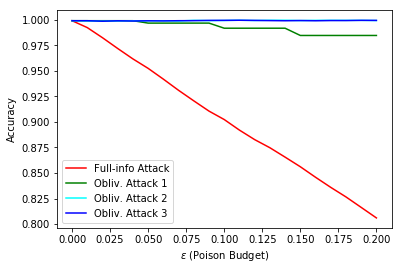

In [19]:
print(list(obliv3_epsilon_avg_dict.values()))
fig = plt.figure()
plt.plot(epsilons, list(nonobliv_epsilon_avg_dict.values()), color='red', label='Full-info Attack')
plt.plot(epsilons, list(obliv1_epsilon_avg_dict.values()), color='green', label='Obliv. Attack 1')
plt.plot(epsilons, list(obliv2_epsilon_avg_dict.values()), color='cyan', label='Obliv. Attack 2')
plt.plot(epsilons, list(obliv3_epsilon_avg_dict.values()), color='blue', label='Obliv. Attack 3')
plt.legend()
plt.xlabel("$\epsilon$ (Poison Budget)")
plt.ylabel("Accuracy")

In [20]:
fig.savefig('classification_sep.png', dpi=600)